# Определение возраста покупателей



Цель проекта: построить модель определения возраста человека по фото.  
Заказчик: Сетевой супермаркет «Хлеб-Соль»  

*Описание проекта*  
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

-Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;\
-Контролировать добросовестность кассиров при продаже алкоголя.

Задачи:  
-Провесть исследовательский анализ набора фотографий  
-Подготовить данные к обучению  
-Обучить нейронную сеть и рассчитать её качество

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#грузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# Посмотрим на размер выборки
labels.shape

(7591, 2)

In [4]:
# Посмотрим на содержимое датасета
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


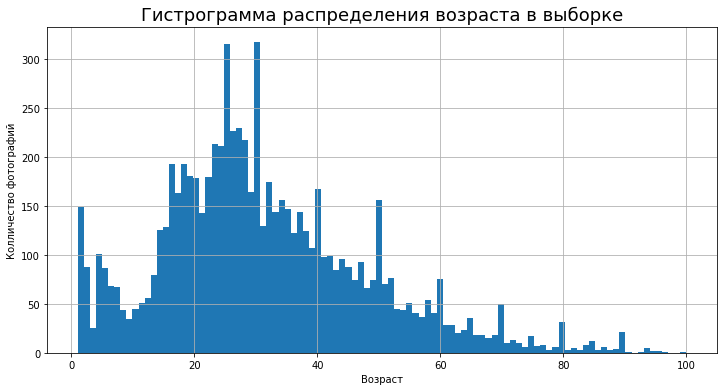

In [6]:
# график распределения возраста в выборке
labels.hist(bins=100, figsize=(12, 6))
plt.title('Гистрограмма распределения возраста в выборке',size = 18)
plt.xlabel('Возраст')
plt.ylabel('Колличество фотографий')
plt.show() 

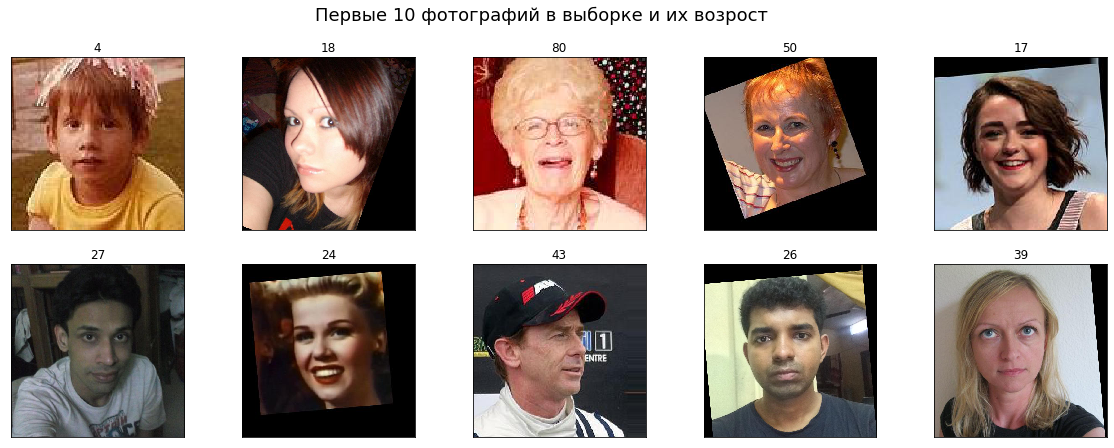

In [7]:
# график первых 10ти фотографий в выборке и их возростов
path = '/datasets/faces/final_files/'
pic_box = plt.figure(figsize=(20,7))
for i, file_name in enumerate(labels.file_name[:10]):
    image = Image.open(path + file_name)
    pic_box.add_subplot(2,5,i+1).set(title = labels.real_age[i], xticks=[], yticks=[])
    plt.imshow(np.array(image))
plt.suptitle('Первые 10 фотографий в выборке и их возрост', size = 18)
plt.show() 

**Вывод.** Датасет представляет из себя 7591 фотографию людей с соответсвующим возрастом. Фотографии храниятся в папке /datasets/faces/final_files/. Таблица соотвествия имения файла и возраста хранится в файле labels.csv. Фотографии цветные и имеют разное разрешение. График распределения показывает, что наибольшее колличество фотографий соответсвует возрасту 20-30 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    
    return train_datagen_flow
        
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-01-02 18:58:05.696681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-02 18:58:05.706761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-02 18:58:05.707125: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-01-02 18:58:05.713833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-01-02 18:58:05.714363: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4cd4920 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-02 18:58:05.714389: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-02 18:58:05.857295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d5a940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-02 18:58:05.857332: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-02 18:58:05.859782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-02 18:58:05.864381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-02 18:58:06.177918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-02 18:58:06.177970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-01-02 18:58:06.177980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-01-02 18:58:06.182502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-01-02 18:58:17.262245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-02 18:58:17.560053: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 207.1174 - mae: 10.3764 - val_loss: 878.8924 - val_mae: 24.7827
Epoch 2/10
178/178 - 37s - loss: 54.5384 - mae: 5.5868 - val_loss: 582.0819 - val_mae: 18.8263
Epoch 3/10
178/178 - 37s - loss: 27.8135 - mae: 4.0421 - val_loss: 253.0826 - val_mae: 11.8807
Epoch 4/10
178/178 - 37s - loss: 17.7244 - mae: 3.2139 - val_loss: 131.0176 - val_mae: 8.9130
Epoch 5/10
178/178 - 37s - loss: 11.7325 - mae: 2.6256 - val_loss: 78.4907 - val_mae: 6.6234
Epoch 6/10
178/178 - 38s - loss: 11.0748 - mae: 2.4876 - val_loss: 71.3912 - val_mae: 6.5034
Epoch 7/10
178/178 - 38s - loss: 9.4547 - mae: 2.3224 - val_loss: 73.1628 - val_mae: 6.7131
Epoch 8/10
178/178 - 38s - loss: 8.6567 - mae: 2.1880 - val_loss: 69.4297 - val_mae: 6.2961
Epoch 9/10
178/178 - 38s - loss: 7.3260 - mae: 2.0305 - val_loss: 69.8886 - val_mae: 6.4382
Epoch 10/10
178/178 - 37s - loss: 6.2650 - mae: 1.8785 - val_loss: 65.5138 - val_mae: 6.1241
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.5138 - mae: 6.1241
Test MAE: 6.1241


```

Если добавить в ImageDataGenerator() параметр
```python 
horizontal_flip=True
```
то результат немного улучшится.

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-01-10 21:59:50.099488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-10 21:59:51.534738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-10 21:59:51.535229: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-01-10 21:59:51.749933: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-01-10 21:59:51.755004: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x439e690 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-10 21:59:51.755042: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-10 21:59:52.149549: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x44246b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-10 21:59:52.149590: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-10 21:59:52.152038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-10 21:59:52.156528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-10 21:59:52.170120: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-10 21:59:57.514422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-10 21:59:57.514475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-01-10 21:59:57.514486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-01-10 21:59:57.549979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-01-10 22:00:35.294204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-10 22:00:38.796078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 106s - loss: 222.9392 - mae: 10.6544 - val_loss: 791.7491 - val_mae: 23.2194
Epoch 2/10
178/178 - 38s - loss: 70.2371 - mae: 6.3762 - val_loss: 538.7290 - val_mae: 17.9494
Epoch 3/10
178/178 - 37s - loss: 49.6956 - mae: 5.3155 - val_loss: 283.8793 - val_mae: 12.4969
Epoch 4/10
178/178 - 38s - loss: 32.5547 - mae: 4.3363 - val_loss: 106.6472 - val_mae: 7.8479
Epoch 5/10
178/178 - 38s - loss: 23.5077 - mae: 3.6969 - val_loss: 76.4019 - val_mae: 6.6341
Epoch 6/10
178/178 - 37s - loss: 18.4628 - mae: 3.2370 - val_loss: 84.7531 - val_mae: 6.8609
Epoch 7/10
178/178 - 38s - loss: 14.3006 - mae: 2.8970 - val_loss: 66.5553 - val_mae: 6.0040
Epoch 8/10
178/178 - 37s - loss: 12.2633 - mae: 2.6647 - val_loss: 64.5385 - val_mae: 5.9542
Epoch 9/10
178/178 - 37s - loss: 10.8654 - mae: 2.4770 - val_loss: 64.5630 - val_mae: 5.9512
Epoch 10/10
178/178 - 38s - loss: 9.8172 - mae: 2.3571 - val_loss: 63.8613 - val_mae: 5.8955
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 63.8613 - mae: 5.8955
Test MAE: 5.8955
```

## Анализ обученной модели

Потпроена и обучена модель определения возраста человека по фотографии. Тренировочный датасет состоял из цветных фотографий в котором преобладали лица с возрастом 20-30 лет. За основу была взята сеть ResNet50 с весами imagenet. К ней добавили слой пуллинга c глобальным усреднением и 2 полносвязных слоя. Метрика MAE = 6.1 удовлетворяет условиям задачи <8. Судя по логам обучения на достижение целевой метрики достаточно 5 эпох. Последующие 5 эпох значительно менее эффективны, что говорит о приближении к натлучшему результату для данной конфигурации нейросети.  
**Оценка спостобности модели решать бизнес-задачи**\
Исходя из того, что метрика MAE показывает среднюю абсолютную ошибку можно сделать выводы о способности модели решать бизнес-задачи. 
Для анализа покупок покупателей некоторой возростной группы данная модель вполне годится учитывая среднюю ошибку в 6 лет.
Для контроля продажи алкоголя точности модели недостаточно. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы